Using device: cuda
STARTING TRAINING (ROBUST SCALING + RANDOM CROP)
Loading data files...
Found 540 PID files and 540 RE (MICS) files.
Loaded 540 valid files suitable for training.
Fitting StandardScalers on dataset...
Scaler stats - MICS Mean: 0.4922, PID Mean: 0.2056
Epoch 1/150 | Train Loss: 3.90332 | Val Loss: 2.73492
  >>> New Best Model Saved
Epoch 2/150 | Train Loss: 3.07828 | Val Loss: 2.74359
Epoch 3/150 | Train Loss: 2.43050 | Val Loss: 2.74722
Epoch 4/150 | Train Loss: 2.12386 | Val Loss: 2.75093
Epoch 5/150 | Train Loss: 1.92478 | Val Loss: 2.75565
Epoch 6/150 | Train Loss: 1.85822 | Val Loss: 2.76261
Epoch 7/150 | Train Loss: 1.84411 | Val Loss: 2.76311
Epoch 8/150 | Train Loss: 1.85691 | Val Loss: 2.76909
Epoch 9/150 | Train Loss: 1.71716 | Val Loss: 2.77341
Epoch 10/150 | Train Loss: 1.63283 | Val Loss: 2.77838
Epoch 11/150 | Train Loss: 1.58421 | Val Loss: 2.78257
Epoch 12/150 | Train Loss: 1.63052 | Val Loss: 2.78245
Epoch 13/150 | Train Loss: 1.58023 | Val Loss: 2.783

C:\Users\ackel\AppData\Local\Temp\ipykernel_30264\3236817142.py:310: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_D

Plots saved to models_wavenet_v3_robust


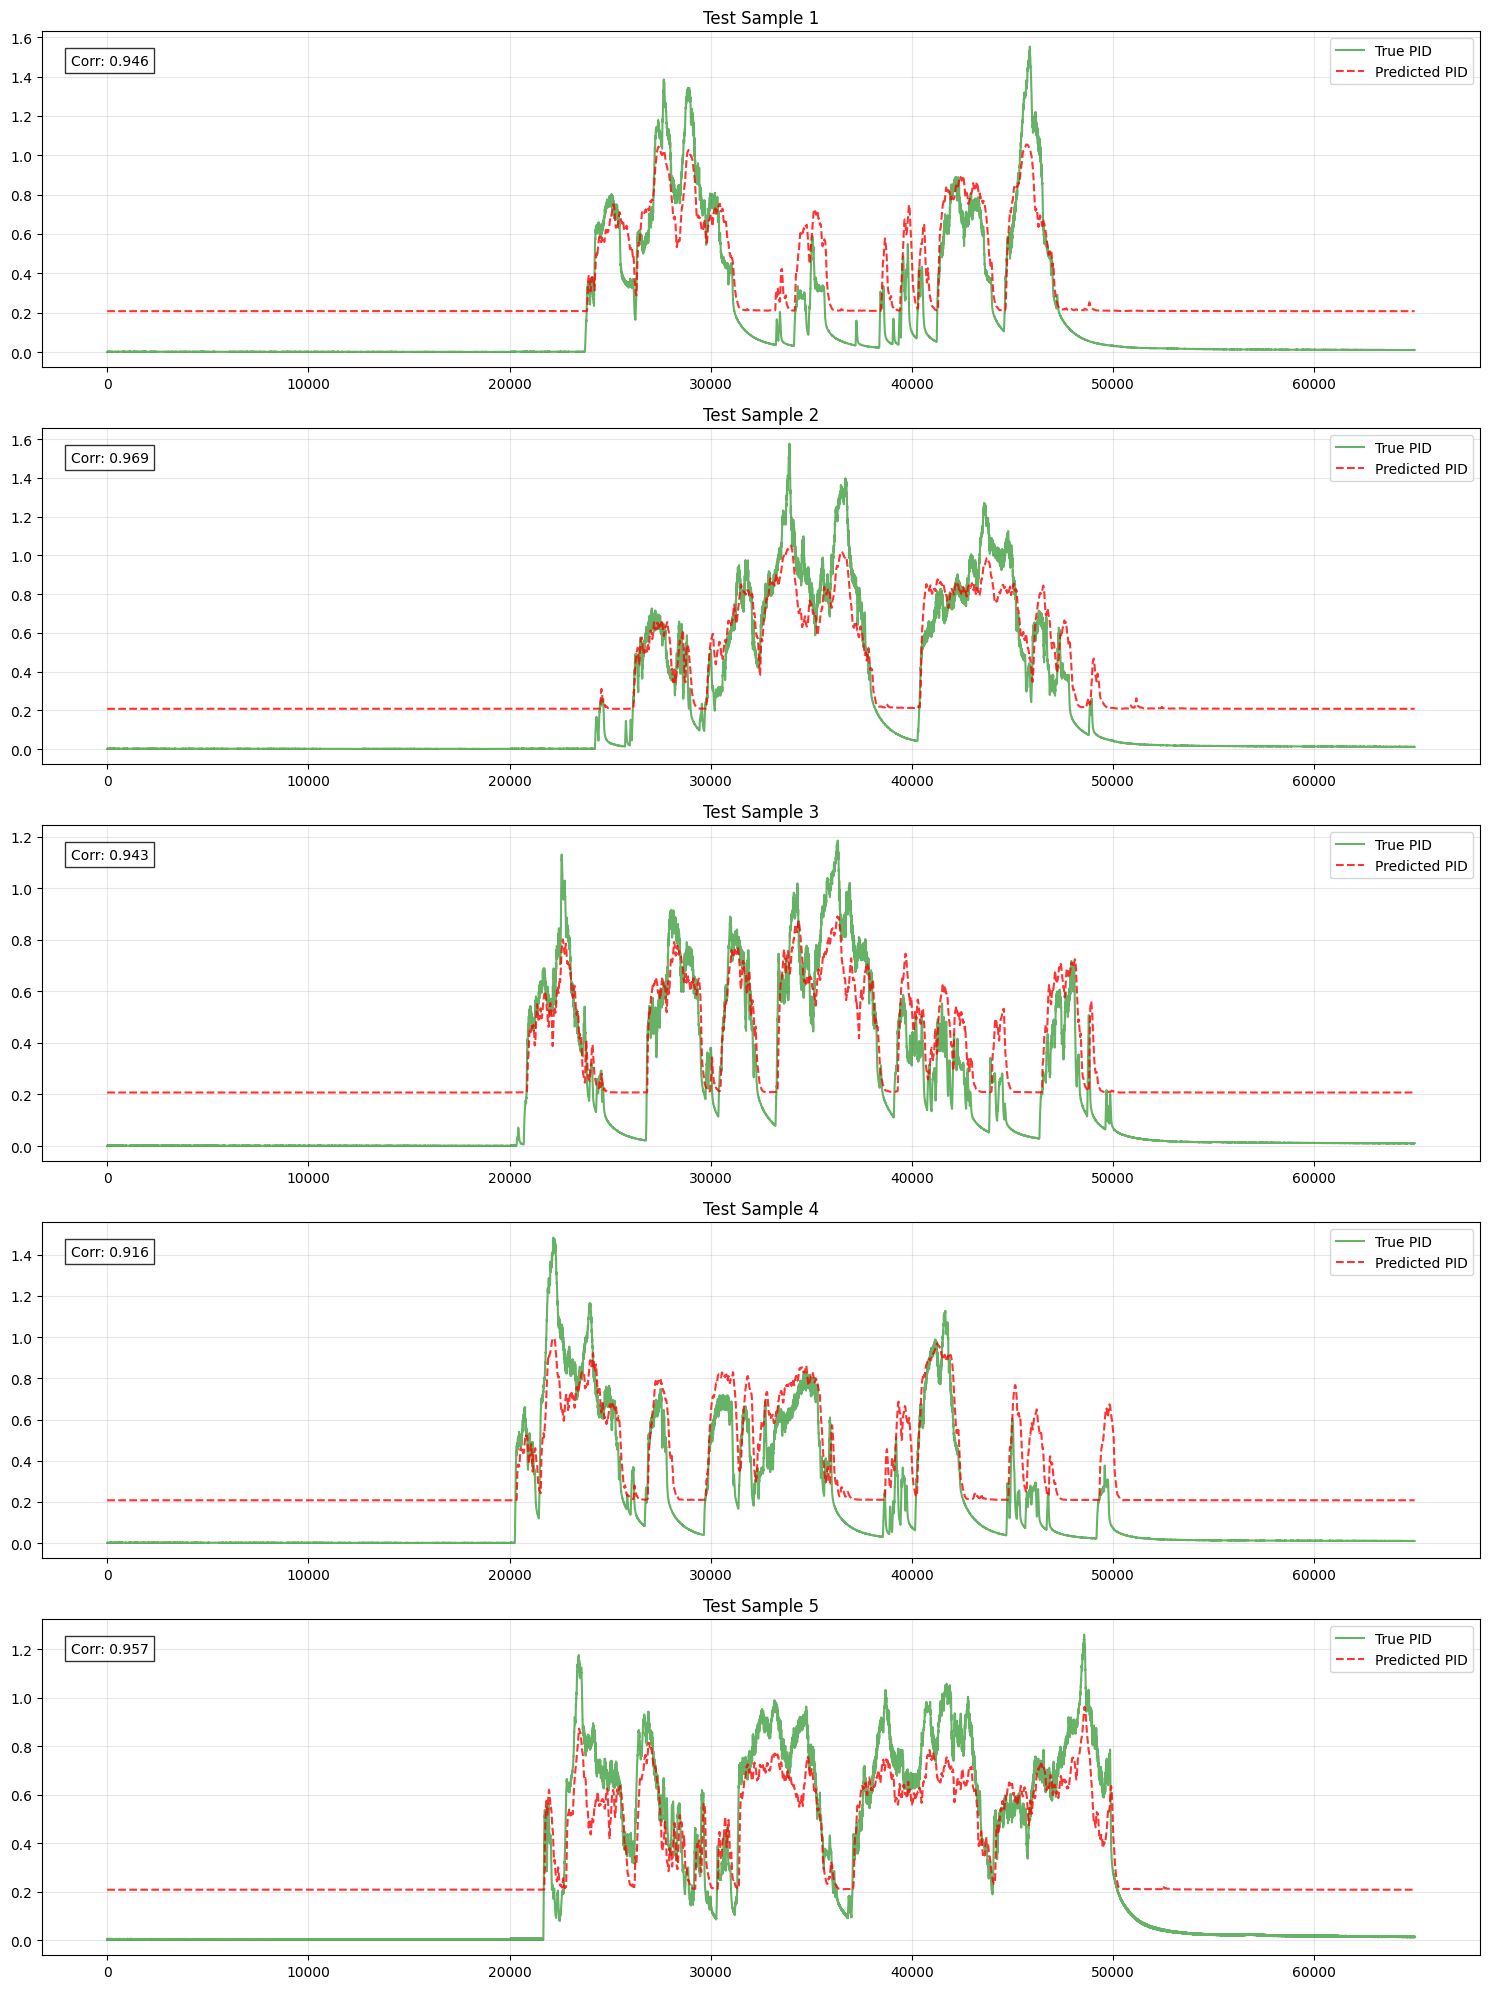

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from torchaudio.transforms import Spectrogram
import os
import glob
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ==========================================
# CONFIGURATION
# ==========================================
# Ensure these paths point to the folder containing your .npy files
PID_DATA_DIR = "E:\\CNN data\\180_plumes\\180_Plumes\\AT\\individual_repeats_npy\\PID"
MICS_DATA_DIR = "E:\\CNN data\\180_plumes\\180_Plumes\\AT\\individual_repeats_npy\\MICS\\RE"

# Hyperparameters
INITIAL_EPOCHS = 150
BATCH_SIZE = 16          # 16 is a good balance for stability
TRAIN_CROP_LENGTH = 4096 # CRITICAL: Model trains on random windows of this size
MODEL_SAVE_DIR = "models_wavenet_v3_robust"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# SCALERS: Using StandardScaler to handle outliers in the larger dataset
mics_scaler = StandardScaler()
pid_scaler = StandardScaler()

# ==========================================
# PRE-PROCESSING UTILS
# ==========================================
def apply_low_pass_filter(data, cutoff_hz, fs=1000, order=4):
    """Applies Butterworth low-pass filter to remove high-freq noise from PID."""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_hz / nyquist
    sos = signal.butter(order, normal_cutoff, btype='low', analog=False, output='sos')
    return signal.sosfilt(sos, data)

# ==========================================
# DATASET (RANDOM CROP)
# ==========================================
class RandomCropDataset(Dataset):
    def __init__(self, mics_data, pid_data, crop_length, is_train=True):
        self.mics_data = mics_data
        self.pid_data = pid_data
        self.crop_length = crop_length
        self.is_train = is_train

    def __len__(self):
        return len(self.mics_data)

    def __getitem__(self, idx):
        mics_raw = self.mics_data[idx]
        pid_raw = self.pid_data[idx]
        total_len = len(mics_raw)

        # Safety check for short files (though unlikely with your data)
        if total_len <= self.crop_length:
            start_idx = 0
            # Pad if shorter
            mics_segment = np.pad(mics_raw, (0, self.crop_length - total_len))
            pid_segment = np.pad(pid_raw, (0, self.crop_length - total_len))
        else:
            if self.is_train:
                # TRAINING: Random crop (Data Augmentation)
                start_idx = np.random.randint(0, total_len - self.crop_length)
            else:
                # VALIDATION: Center crop (Deterministic)
                start_idx = (total_len - self.crop_length) // 2
            
            mics_segment = mics_raw[start_idx : start_idx + self.crop_length]
            pid_segment = pid_raw[start_idx : start_idx + self.crop_length]

        # Apply Scaling (Global Standard Scaler)
        mics_norm = mics_scaler.transform(mics_segment.reshape(-1, 1)).flatten()
        pid_norm = pid_scaler.transform(pid_segment.reshape(-1, 1)).flatten()

        # Feature Engineering: 1st and 2nd Derivatives
        mics_d1 = np.gradient(mics_norm)
        mics_d2 = np.gradient(mics_d1)
        
        # Stack features: [Channel, Time] -> (3, 4096)
        mics_features = np.stack([mics_norm, mics_d1, mics_d2], axis=0)
        
        # Add slight noise during training for robustness
        mics_tensor = torch.FloatTensor(mics_features)
        if self.is_train:
            mics_tensor += torch.randn_like(mics_tensor) * 0.01

        pid_tensor = torch.FloatTensor(pid_norm).unsqueeze(0) # (1, 4096)

        return mics_tensor, pid_tensor

# ==========================================
# MODEL ARCHITECTURE
# ==========================================
class WaveNetResidualBlock(nn.Module):
    def __init__(self, res_channels, skip_channels, kernel_size, dilation, dropout=0.1):
        super(WaveNetResidualBlock, self).__init__()
        self.dilated_conv = nn.Conv1d(res_channels, 2 * res_channels, kernel_size,
                                      padding=(kernel_size - 1) * dilation,
                                      dilation=dilation, padding_mode='replicate')
        self.res_conv = nn.Conv1d(res_channels, res_channels, 1)
        self.skip_conv = nn.Conv1d(res_channels, skip_channels, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x_dilated = self.dilated_conv(x)
        # Trim extra padding caused by dilation
        x_dilated = x_dilated[:, :, :residual.size(2)] 
        
        out_tanh, out_sigmoid = torch.chunk(x_dilated, 2, dim=1)
        gated_activation = torch.tanh(out_tanh) * torch.sigmoid(out_sigmoid)
        gated_activation = self.dropout(gated_activation)
        
        res_out = self.res_conv(gated_activation)
        skip_out = self.skip_conv(gated_activation)
        return res_out + residual, skip_out

class WaveNetModel(nn.Module):
    def __init__(self, in_channels=3, res_channels=64, skip_channels=128,
                 num_blocks=8, num_cycles=3, kernel_size=3):
        super(WaveNetModel, self).__init__()
        self.initial_conv = nn.Conv1d(in_channels, res_channels, kernel_size=1)
        self.residual_blocks = nn.ModuleList()
        for _ in range(num_cycles):
            for i in range(num_blocks):
                dilation = 2**i
                self.residual_blocks.append(
                    WaveNetResidualBlock(res_channels, skip_channels, kernel_size, dilation))
        self.final_conv1 = nn.Conv1d(skip_channels, skip_channels, 1)
        self.final_conv2 = nn.Conv1d(skip_channels, 1, 1)

    def forward(self, x):
        x = self.initial_conv(x)
        skip_connections = []
        for block in self.residual_blocks:
            x, skip = block(x)
            skip_connections.append(skip)
        
        total_skip = sum(skip_connections)
        out = F.relu(total_skip)
        out = self.final_conv1(out)
        out = F.relu(out)
        out = self.final_conv2(out)
        return out

# ==========================================
# LOSS FUNCTION
# ==========================================
class FrequencyShapeLoss(nn.Module):
    def __init__(self):
        super(FrequencyShapeLoss, self).__init__()
        self.l1 = nn.L1Loss()
        # Multi-resolution STFT
        self.stft_configs = [
            Spectrogram(n_fft=1024, hop_length=256, power=2).to(device),
            Spectrogram(n_fft=512, hop_length=128, power=2).to(device)
        ]

    def forward(self, y_pred, y_true):
        # 1. Time Domain Loss
        time_loss = self.l1(y_pred, y_true)
        
        # 2. Derivative Loss (Shape matching)
        pred_diff = torch.diff(y_pred, dim=2)
        true_diff = torch.diff(y_true, dim=2)
        shape_loss = self.l1(pred_diff, true_diff)
        
        # 3. Spectral Loss
        spec_loss = 0.0
        for stft in self.stft_configs:
            # Log magnitude spectrogram
            p_spec = torch.log(stft(y_pred.squeeze(1)) + 1e-5)
            t_spec = torch.log(stft(y_true.squeeze(1)) + 1e-5)
            spec_loss += self.l1(p_spec, t_spec)
        spec_loss /= len(self.stft_configs)
        
        return 1.0 * time_loss + 1.5 * shape_loss + 0.5 * spec_loss

# ==========================================
# TRAINING LOOP
# ==========================================
def train_model():
    print("="*50)
    print("STARTING TRAINING (ROBUST SCALING + RANDOM CROP)")
    print("="*50)
    
    # 1. Load Data
    # ----------------
    print("Loading data files...")
    # NOTE: Updated file pattern for MICS to RE_plume_...
    pid_files = sorted(glob.glob(os.path.join(PID_DATA_DIR, "PID_plume_AT*.npy")))
    mics_files = sorted(glob.glob(os.path.join(MICS_DATA_DIR, "RE_plume_AT*.npy")))
    
    if not pid_files or not mics_files:
        print("ERROR: No files found. Check paths and naming conventions.")
        print(f"Looking for PID in: {os.path.join(PID_DATA_DIR, 'PID_plume_AT*.npy')}")
        print(f"Looking for MICS in: {os.path.join(MICS_DATA_DIR, 'RE_plume_AT*.npy')}")
        return

    print(f"Found {len(pid_files)} PID files and {len(mics_files)} RE (MICS) files.")

    # Load into memory (List of arrays)
    all_pid = [apply_low_pass_filter(np.load(f), 330) for f in pid_files]
    all_mics = [np.load(f) for f in mics_files]
    
    # Filter out files shorter than crop length
    valid_indices = [i for i, x in enumerate(all_mics) if len(x) > TRAIN_CROP_LENGTH]
    all_pid = [all_pid[i] for i in valid_indices]
    all_mics = [all_mics[i] for i in valid_indices]
    
    print(f"Loaded {len(all_pid)} valid files suitable for training.")

    # 2. Fit Scalers (Global Statistics)
    # ----------------
    print("Fitting StandardScalers on dataset...")
    # To save memory, we sample points to fit the scaler
    sample_mics = np.concatenate([x[::20] for x in all_mics])
    sample_pid = np.concatenate([x[::20] for x in all_pid])
    
    mics_scaler.fit(sample_mics.reshape(-1, 1))
    pid_scaler.fit(sample_pid.reshape(-1, 1))
    print(f"Scaler stats - MICS Mean: {mics_scaler.mean_[0]:.4f}, PID Mean: {pid_scaler.mean_[0]:.4f}")

    # 3. Train/Val Split
    # ----------------
    mics_train, mics_val, pid_train, pid_val = train_test_split(
        all_mics, all_pid, test_size=0.15, random_state=42
    )
    
    # 4. Create Datasets & Loaders
    # ----------------
    train_ds = RandomCropDataset(mics_train, pid_train, TRAIN_CROP_LENGTH, is_train=True)
    val_ds = RandomCropDataset(mics_val, pid_val, TRAIN_CROP_LENGTH, is_train=False)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # 5. Initialize Model
    # ----------------
    model = WaveNetModel(in_channels=3).to(device)
    criterion = FrequencyShapeLoss().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
    scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=INITIAL_EPOCHS)

    # 6. Training Loop
    # ----------------
    best_val_loss = float('inf')
    history = {'train': [], 'val': []}

    for epoch in range(INITIAL_EPOCHS):
        # --- TRAIN ---
        model.train()
        train_loss = 0.0
        for mics_b, pid_b in train_loader:
            mics_b, pid_b = mics_b.to(device), pid_b.to(device)
            
            optimizer.zero_grad()
            outputs = model(mics_b)
            loss = criterion(outputs, pid_b)
            
            loss.backward()
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)

        # --- VALIDATE ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for mics_b, pid_b in val_loader:
                mics_b, pid_b = mics_b.to(device), pid_b.to(device)
                outputs = model(mics_b)
                val_loss += criterion(outputs, pid_b).item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        history['train'].append(avg_train_loss)
        history['val'].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{INITIAL_EPOCHS} | Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}")

        # Save Best
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), os.path.join(MODEL_SAVE_DIR, "best_model_robust.pth"))
            print("  >>> New Best Model Saved")

    # 7. Final Plots
    # ----------------
    plot_training_results(history)
    
    # Run full sequence inference on a few validation files
    model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_DIR, "best_model_robust.pth")))
    run_full_inference_check(model, mics_val[:5], pid_val[:5])

# ==========================================
# PLOTTING & INFERENCE
# ==========================================
def plot_training_results(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history['train'], label='Train Loss')
    plt.plot(history['val'], label='Val Loss')
    plt.title('Training History (Robust Scaling)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(MODEL_SAVE_DIR, "training_history.png"))
    plt.close()

def predict_full_sequence(model, mics_raw):
    """
    Runs inference on a FULL variable-length signal.
    """
    model.eval()
    
    # 1. Preprocess full signal
    mics_norm = mics_scaler.transform(mics_raw.reshape(-1, 1)).flatten()
    mics_d1 = np.gradient(mics_norm)
    mics_d2 = np.gradient(mics_d1)
    
    features = np.stack([mics_norm, mics_d1, mics_d2], axis=0) # (3, Length)
    
    # 2. To Tensor
    input_tensor = torch.FloatTensor(features).unsqueeze(0).to(device) # (1, 3, Length)
    
    # 3. Predict
    with torch.no_grad():
        # If signal is massive (>50k samples), slicing might be needed. 
        # Assuming fits in VRAM for now based on previous context.
        pred_norm = model(input_tensor).cpu().numpy().squeeze()
    
    # 4. Inverse Transform
    pred_real = pid_scaler.inverse_transform(pred_norm.reshape(-1, 1)).flatten()
    return pred_real

def run_full_inference_check(model, mics_list, pid_list):
    print("\nGenerating verification plots for full sequences...")
    
    num_plots = min(len(mics_list), 5)
    fig, axes = plt.subplots(num_plots, 1, figsize=(15, 4 * num_plots))
    if num_plots == 1: axes = [axes]
    
    for i in range(num_plots):
        mics_raw = mics_list[i]
        pid_true = pid_list[i]
        
        pid_pred = predict_full_sequence(model, mics_raw)
        
        # Ensure lengths match for plotting
        min_len = min(len(pid_true), len(pid_pred))
        
        ax = axes[i]
        ax.plot(pid_true[:min_len], 'g-', alpha=0.6, label='True PID')
        ax.plot(pid_pred[:min_len], 'r--', alpha=0.8, label='Predicted PID')
        ax.set_title(f"Test Sample {i+1}")
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Calculate metric
        corr = np.corrcoef(pid_true[:min_len], pid_pred[:min_len])[0, 1]
        ax.text(0.02, 0.9, f"Corr: {corr:.3f}", transform=ax.transAxes, 
                bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_SAVE_DIR, "validation_comparisons.png"))
    print(f"Plots saved to {MODEL_SAVE_DIR}")

if __name__ == "__main__":
    # Reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    train_model()

In [3]:
def plot_train_val_comparison(model, stimulus_type, stimulus_files, train_indices, val_indices):
    print(f"\nGenerating comparison plots for {stimulus_type.upper()}...")
    model.eval()
    
    # Select up to 10 plumes from train and validation
    train_to_plot = train_indices[:10]
    val_to_plot = val_indices[:10]
    
    # Plot training data
    if len(train_to_plot) > 0:
        n_plots = len(train_to_plot)
        fig, axes = plt.subplots(n_plots, 2, figsize=(25, 8 * n_plots), squeeze=False)
        fig.suptitle(f'{stimulus_type.upper()} - TRAINING DATA', fontsize=20, fontweight='bold')
        
        for i, idx in enumerate(train_to_plot):
            pid_data, mics_data = load_stimulus_data(stimulus_files[idx])
            # Use 1st repeat for plotting
            full_pid_original, full_mics = pid_data[0], mics_data[0] 
            
            pred_pid = predict_full_sequence_variable_length(model, full_mics)
            
            min_len = min(len(full_pid_original), len(pred_pid))
            t = np.arange(min_len)
            
            ax_time = axes[i, 0]
            ax_time.plot(t, full_pid_original[:min_len], 'g-', alpha=0.8, label='Actual PID', linewidth=1.5)
            ax_time.plot(t, pred_pid[:min_len], 'r--', alpha=0.9, label='Predicted PID', linewidth=1.5)
            ax_time.set_title(f'Plume {idx} - Time Domain')
            ax_time.set_xlabel('Time (samples)')
            ax_time.set_ylabel('Amplitude')
            ax_time.legend(); ax_time.grid(True, alpha=0.4)
            
            time_corr = np.corrcoef(full_pid_original[:min_len], pred_pid[:min_len])[0, 1]
            rmse = np.sqrt(np.mean((full_pid_original[:min_len] - pred_pid[:min_len])**2))
            ax_time.text(0.02, 0.95, f'Corr: {time_corr:.4f}\nRMSE: {rmse:.4f}', 
                         transform=ax_time.transAxes, va='top', 
                         bbox=dict(boxstyle='round', fc='wheat', alpha=0.8))
            
            freq_metrics = compute_frequency_metrics(full_pid_original[:min_len], pred_pid[:min_len])
            ax_freq = axes[i, 1]
            ax_freq.semilogy(freq_metrics['frequencies'], freq_metrics['psd_true'], 'g-', label='Actual PSD', alpha=0.8)
            ax_freq.semilogy(freq_metrics['frequencies'], freq_metrics['psd_pred'], 'r--', label='Predicted PSD', alpha=0.9)
            ax_freq.axvline(330, color='b', linestyle=':', linewidth=2, label='330Hz Cutoff')
            ax_freq.set_title(f'Plume {idx} - Frequency Domain')
            ax_freq.set_xlabel('Frequency (Hz)'); ax_freq.set_ylabel('PSD')
            ax_freq.legend(); ax_freq.grid(True, alpha=0.4)
            ax_freq.text(0.02, 0.95, f'HF Ratio: {freq_metrics["hf_power_ratio"]:.3f}\nSpec Corr: {freq_metrics["spectral_correlation"]:.4f}', 
                         transform=ax_freq.transAxes, va='top', 
                         bbox=dict(boxstyle='round', fc='lightblue', alpha=0.8))
        
        plt.tight_layout()
        plt.savefig(os.path.join(MODEL_SAVE_DIR, f'comparison_train_{stimulus_type}.png'), dpi=300)
        plt.show()
    
    # Plot validation data
    if len(val_to_plot) > 0:
        n_plots = len(val_to_plot)
        fig, axes = plt.subplots(n_plots, 2, figsize=(25, 8 * n_plots), squeeze=False)
        fig.suptitle(f'{stimulus_type.upper()} - VALIDATION DATA', fontsize=20, fontweight='bold')
        
        for i, idx in enumerate(val_to_plot):
            pid_data, mics_data = load_stimulus_data(stimulus_files[idx])
            full_pid_original, full_mics = pid_data[0], mics_data[0]
            
            pred_pid = predict_full_sequence_variable_length(model, full_mics)
            
            min_len = min(len(full_pid_original), len(pred_pid))
            t = np.arange(min_len)
            
            ax_time = axes[i, 0]
            ax_time.plot(t, full_pid_original[:min_len], 'g-', alpha=0.8, label='Actual PID', linewidth=1.5)
            ax_time.plot(t, pred_pid[:min_len], 'r--', alpha=0.9, label='Predicted PID', linewidth=1.5)
            ax_time.set_title(f'Plume {idx} - Time Domain')
            ax_time.set_xlabel('Time (samples)')
            ax_time.set_ylabel('Amplitude')
            ax_time.legend(); ax_time.grid(True, alpha=0.4)
            
            time_corr = np.corrcoef(full_pid_original[:min_len], pred_pid[:min_len])[0, 1]
            rmse = np.sqrt(np.mean((full_pid_original[:min_len] - pred_pid[:min_len])**2))
            ax_time.text(0.02, 0.95, f'Corr: {time_corr:.4f}\nRMSE: {rmse:.4f}', 
                         transform=ax_time.transAxes, va='top', 
                         bbox=dict(boxstyle='round', fc='wheat', alpha=0.8))
            
            freq_metrics = compute_frequency_metrics(full_pid_original[:min_len], pred_pid[:min_len])
            ax_freq = axes[i, 1]
            ax_freq.semilogy(freq_metrics['frequencies'], freq_metrics['psd_true'], 'g-', label='Actual PSD', alpha=0.8)
            ax_freq.semilogy(freq_metrics['frequencies'], freq_metrics['psd_pred'], 'r--', label='Predicted PSD', alpha=0.9)
            ax_freq.axvline(330, color='b', linestyle=':', linewidth=2, label='330Hz Cutoff')
            ax_freq.set_title(f'Plume {idx} - Frequency Domain')
            ax_freq.set_xlabel('Frequency (Hz)'); ax_freq.set_ylabel('PSD')
            ax_freq.legend(); ax_freq.grid(True, alpha=0.4)
            ax_freq.text(0.02, 0.95, f'HF Ratio: {freq_metrics["hf_power_ratio"]:.3f}\nSpec Corr: {freq_metrics["spectral_correlation"]:.4f}', 
                         transform=ax_freq.transAxes, va='top', 
                         bbox=dict(boxstyle='round', fc='lightblue', alpha=0.8))
        
        plt.tight_layout()
        plt.savefig(os.path.join(MODEL_SAVE_DIR, f'comparison_val_{stimulus_type}.png'), dpi=300)
        plt.show()
        
def train_plume_only():
    print("="*60 + "\nSTARTING ENHANCED PLUME-ONLY TRAINING (v3 - Derivatives Only)\n" + "="*60)
    
    model, stimulus_files, train_indices, val_indices = train_stimulus_type_variable_length(stimulus_type="plume")
    
    if model:
        final_model_name = "final_plume_model_v3_derivs.pth"
        torch.save(model.state_dict(), os.path.join(MODEL_SAVE_DIR, final_model_name))
        print(f"\nPLUME TRAINING COMPLETE! Final model saved as '{final_model_name}'.")
        
        # Generate separate plots for training and validation data
        plot_train_val_comparison(model, "plume", stimulus_files, train_indices, val_indices)

Using device: cuda
STARTING TRAINING (Vertical Align Fix)
Fitting Scalers...
Epoch 1 | Train: 9.4965 | Val: 10.0341
Epoch 2 | Train: 7.8946 | Val: 8.2228
Epoch 3 | Train: 7.1475 | Val: 7.4496
Epoch 4 | Train: 7.1619 | Val: 7.4956
Epoch 5 | Train: 6.8328 | Val: 7.1169
Epoch 6 | Train: 6.9555 | Val: 6.9325
Epoch 7 | Train: 6.7978 | Val: 7.2322
Epoch 8 | Train: 6.7953 | Val: 7.1064
Epoch 9 | Train: 6.3257 | Val: 7.1820
Epoch 10 | Train: 6.3315 | Val: 7.5817
Epoch 11 | Train: 6.1526 | Val: 7.3661
Epoch 12 | Train: 6.6103 | Val: 7.0279
Epoch 13 | Train: 6.3281 | Val: 6.8374
Epoch 14 | Train: 6.2448 | Val: 7.4284
Epoch 15 | Train: 6.4121 | Val: 7.4937
Epoch 16 | Train: 6.0001 | Val: 7.4955
Epoch 17 | Train: 6.3205 | Val: 7.3208
Epoch 18 | Train: 5.8466 | Val: 6.9006
Epoch 19 | Train: 5.7522 | Val: 8.2532
Epoch 20 | Train: 5.8869 | Val: 7.7483
Epoch 21 | Train: 5.6314 | Val: 6.8821
Epoch 22 | Train: 5.7678 | Val: 7.8380
Epoch 23 | Train: 5.2023 | Val: 7.3791
Epoch 24 | Train: 5.0674 | Val: 8.

C:\Users\ackel\AppData\Local\Temp\ipykernel_14868\4097566910.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_D

Comparison plot saved to models_wavenet_v4_aligned


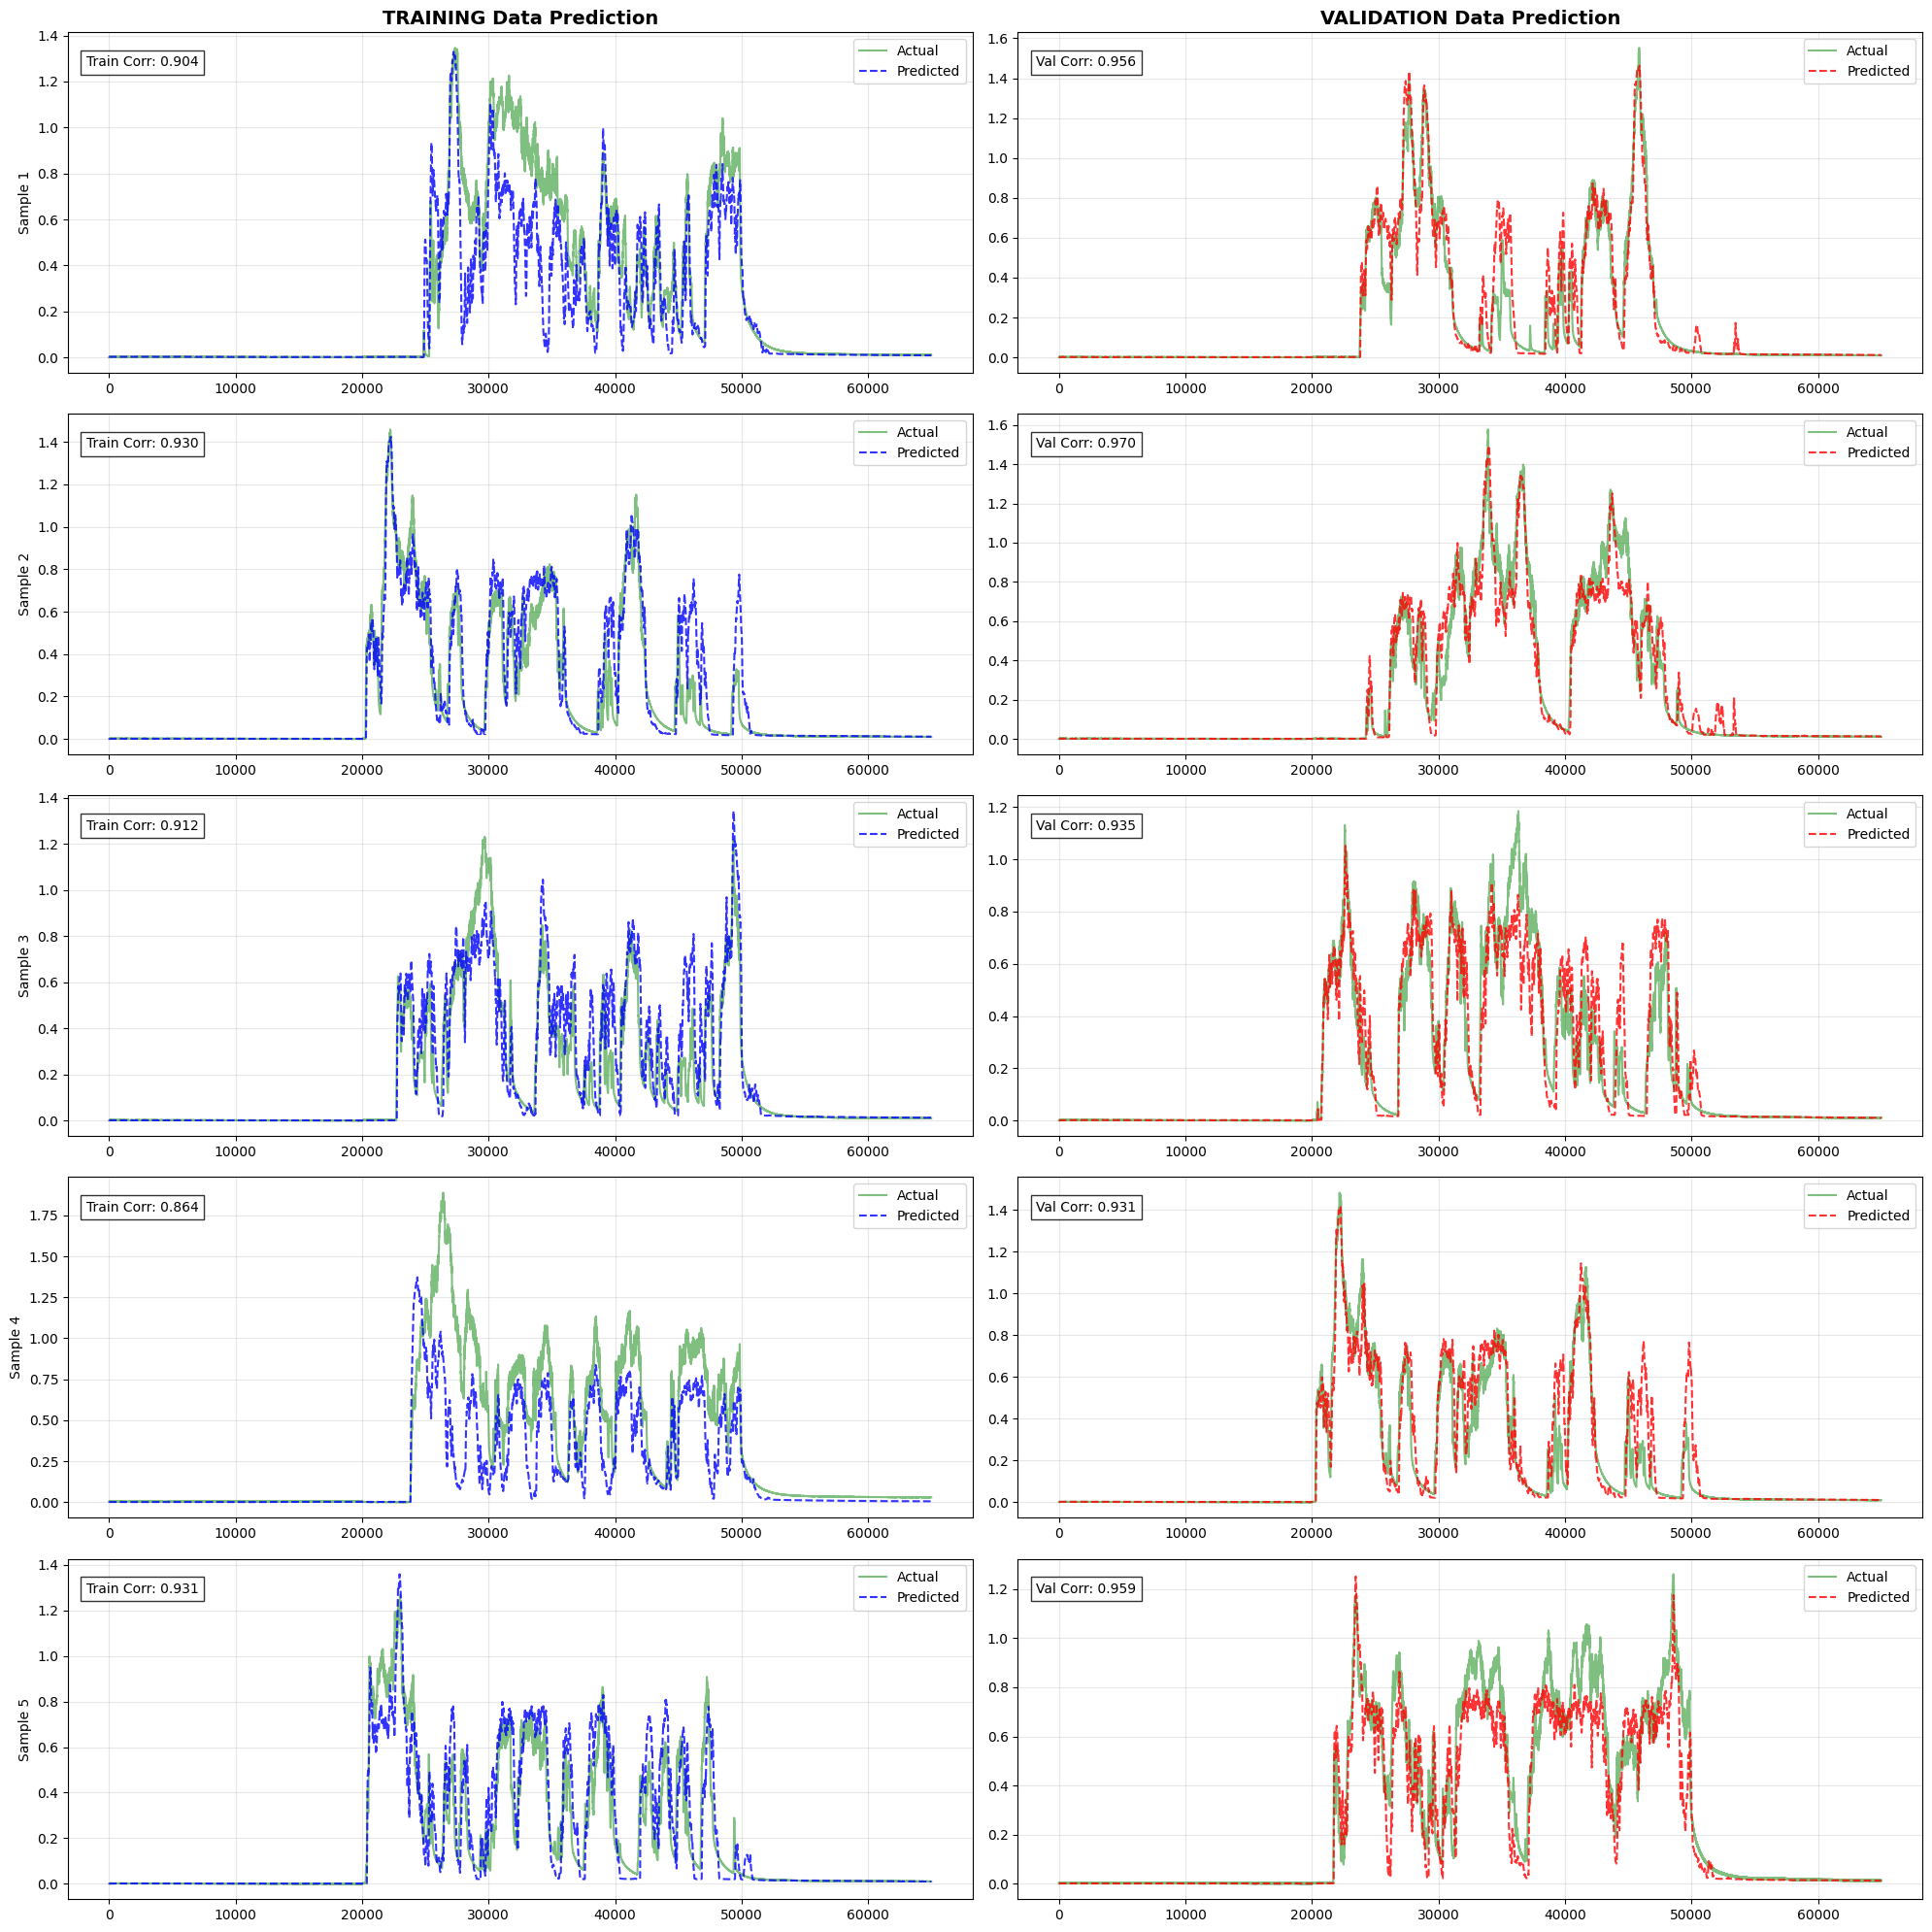

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from torchaudio.transforms import Spectrogram
import os
import glob
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ==========================================
# CONFIGURATION
# ==========================================
PID_DATA_DIR = "E:\\CNN data\\180_plumes\\180_Plumes\\AT\\individual_repeats_npy\\PID"
MICS_DATA_DIR = "E:\\CNN data\\180_plumes\\180_Plumes\\AT\\individual_repeats_npy\\MICS\\RE"

# Hyperparameters
INITIAL_EPOCHS = 450
BATCH_SIZE = 16
TRAIN_CROP_LENGTH = 4096 
MODEL_SAVE_DIR = "models_wavenet_v4_aligned"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Scalers
mics_scaler = StandardScaler()
pid_scaler = StandardScaler()

# ==========================================
# PRE-PROCESSING
# ==========================================
def apply_low_pass_filter(data, cutoff_hz, fs=1000, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_hz / nyquist
    sos = signal.butter(order, normal_cutoff, btype='low', analog=False, output='sos')
    return signal.sosfilt(sos, data)

# ==========================================
# DATASET
# ==========================================
class RandomCropDataset(Dataset):
    def __init__(self, mics_data, pid_data, crop_length, is_train=True):
        self.mics_data = mics_data
        self.pid_data = pid_data
        self.crop_length = crop_length
        self.is_train = is_train

    def __len__(self):
        return len(self.mics_data)

    def __getitem__(self, idx):
        mics_raw = self.mics_data[idx]
        pid_raw = self.pid_data[idx]
        total_len = len(mics_raw)

        if total_len <= self.crop_length:
            start_idx = 0
            mics_segment = np.pad(mics_raw, (0, self.crop_length - total_len))
            pid_segment = np.pad(pid_raw, (0, self.crop_length - total_len))
        else:
            if self.is_train:
                start_idx = np.random.randint(0, total_len - self.crop_length)
            else:
                start_idx = (total_len - self.crop_length) // 2
            
            mics_segment = mics_raw[start_idx : start_idx + self.crop_length]
            pid_segment = pid_raw[start_idx : start_idx + self.crop_length]

        mics_norm = mics_scaler.transform(mics_segment.reshape(-1, 1)).flatten()
        pid_norm = pid_scaler.transform(pid_segment.reshape(-1, 1)).flatten()

        mics_d1 = np.gradient(mics_norm)
        mics_d2 = np.gradient(mics_d1)
        
        mics_features = np.stack([mics_norm, mics_d1, mics_d2], axis=0)
        mics_tensor = torch.FloatTensor(mics_features)
        
        # Slightly reduced noise injection to help precision
        if self.is_train:
            mics_tensor += torch.randn_like(mics_tensor) * 0.005

        pid_tensor = torch.FloatTensor(pid_norm).unsqueeze(0)

        return mics_tensor, pid_tensor

# ==========================================
# MODEL
# ==========================================
class WaveNetResidualBlock(nn.Module):
    def __init__(self, res_channels, skip_channels, kernel_size, dilation, dropout=0.1):
        super(WaveNetResidualBlock, self).__init__()
        self.dilated_conv = nn.Conv1d(res_channels, 2 * res_channels, kernel_size,
                                      padding=(kernel_size - 1) * dilation,
                                      dilation=dilation, padding_mode='replicate')
        self.res_conv = nn.Conv1d(res_channels, res_channels, 1)
        self.skip_conv = nn.Conv1d(res_channels, skip_channels, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x_dilated = self.dilated_conv(x)
        x_dilated = x_dilated[:, :, :residual.size(2)] 
        
        out_tanh, out_sigmoid = torch.chunk(x_dilated, 2, dim=1)
        gated_activation = torch.tanh(out_tanh) * torch.sigmoid(out_sigmoid)
        gated_activation = self.dropout(gated_activation)
        
        res_out = self.res_conv(gated_activation)
        skip_out = self.skip_conv(gated_activation)
        return res_out + residual, skip_out

class WaveNetModel(nn.Module):
    def __init__(self, in_channels=3, res_channels=64, skip_channels=128,
                 num_blocks=8, num_cycles=3, kernel_size=3):
        super(WaveNetModel, self).__init__()
        self.initial_conv = nn.Conv1d(in_channels, res_channels, kernel_size=1)
        self.residual_blocks = nn.ModuleList()
        for _ in range(num_cycles):
            for i in range(num_blocks):
                dilation = 2**i
                self.residual_blocks.append(
                    WaveNetResidualBlock(res_channels, skip_channels, kernel_size, dilation))
        self.final_conv1 = nn.Conv1d(skip_channels, skip_channels, 1)
        self.final_conv2 = nn.Conv1d(skip_channels, 1, 1)

    def forward(self, x):
        x = self.initial_conv(x)
        skip_connections = []
        for block in self.residual_blocks:
            x, skip = block(x)
            skip_connections.append(skip)
        
        total_skip = sum(skip_connections)
        out = F.relu(total_skip)
        out = self.final_conv1(out)
        out = F.relu(out)
        out = self.final_conv2(out)
        return out

# ==========================================
# IMPROVED LOSS FUNCTION (Fixes Vertical Shift)
# ==========================================
class PreciseAlignLoss(nn.Module):
    def __init__(self):
        super(PreciseAlignLoss, self).__init__()
        self.l1 = nn.L1Loss()
        # STFT for frequency consistency
        self.stft_loss = Spectrogram(n_fft=1024, hop_length=256, power=2).to(device)

    def forward(self, y_pred, y_true):
        # 1. Standard MAE (Increased importance)
        mae = self.l1(y_pred, y_true)
        
        # 2. Bias/DC Offset Penalty (CRITICAL FIX)
        # This calculates the difference in the MEAN of the signals
        # If the prediction is shifted up/down, this penalty spikes.
        bias_loss = torch.abs(torch.mean(y_pred, dim=2) - torch.mean(y_true, dim=2)).mean()
        
        # 3. Shape/Derivative Loss
        pred_diff = torch.diff(y_pred, dim=2)
        true_diff = torch.diff(y_true, dim=2)
        shape_loss = self.l1(pred_diff, true_diff)
        
        # 4. Spectral Loss
        p_spec = torch.log(self.stft_loss(y_pred.squeeze(1)) + 1e-5)
        t_spec = torch.log(self.stft_loss(y_true.squeeze(1)) + 1e-5)
        spec_loss = self.l1(p_spec, t_spec)
        
        # WEIGHTS:
        # High weight on MAE and Bias to force vertical alignment.
        total = (4.0 * mae) + (5.0 * bias_loss) + (1.0 * shape_loss) + (0.5 * spec_loss)
        return total

# ==========================================
# TRAINING & PLOTTING
# ==========================================
def train_model():
    print("="*50 + "\nSTARTING TRAINING (Vertical Align Fix)\n" + "="*50)
    
    # Load Files
    pid_files = sorted(glob.glob(os.path.join(PID_DATA_DIR, "PID_plume_AT*.npy")))
    mics_files = sorted(glob.glob(os.path.join(MICS_DATA_DIR, "RE_plume_AT*.npy")))
    
    if not pid_files: return print("No files found.")

    all_pid = [apply_low_pass_filter(np.load(f), 330) for f in pid_files]
    all_mics = [np.load(f) for f in mics_files]
    
    valid_indices = [i for i, x in enumerate(all_mics) if len(x) > TRAIN_CROP_LENGTH]
    all_pid = [all_pid[i] for i in valid_indices]
    all_mics = [all_mics[i] for i in valid_indices]

    # Fit Scalers
    print("Fitting Scalers...")
    sample_mics = np.concatenate([x[::20] for x in all_mics])
    sample_pid = np.concatenate([x[::20] for x in all_pid])
    mics_scaler.fit(sample_mics.reshape(-1, 1))
    pid_scaler.fit(sample_pid.reshape(-1, 1))

    # Split
    mics_train, mics_val, pid_train, pid_val = train_test_split(all_mics, all_pid, test_size=0.15, random_state=42)
    
    train_ds = RandomCropDataset(mics_train, pid_train, TRAIN_CROP_LENGTH, is_train=True)
    val_ds = RandomCropDataset(mics_val, pid_val, TRAIN_CROP_LENGTH, is_train=False)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = WaveNetModel(in_channels=3).to(device)
    criterion = PreciseAlignLoss().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
    scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=INITIAL_EPOCHS)

    best_val_loss = float('inf')

    for epoch in range(INITIAL_EPOCHS):
        model.train()
        train_loss = 0.0
        for m, p in train_loader:
            m, p = m.to(device), p.to(device)
            optimizer.zero_grad()
            out = model(m)
            loss = criterion(out, p)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for m, p in val_loader:
                m, p = m.to(device), p.to(device)
                val_loss += criterion(model(m), p).item()
                
        print(f"Epoch {epoch+1} | Train: {train_loss/len(train_loader):.4f} | Val: {val_loss/len(val_loader):.4f}")
        
        if (val_loss/len(val_loader)) < best_val_loss:
            best_val_loss = val_loss/len(val_loader)
            torch.save(model.state_dict(), os.path.join(MODEL_SAVE_DIR, "best_model_aligned.pth"))

    # --- PLOTTING UPDATE ---
    # We pass both train and val data to the plotting function
    model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_DIR, "best_model_aligned.pth")))
    plot_comparison_split(model, mics_train, pid_train, mics_val, pid_val)

def predict_full_sequence(model, mics_raw):
    model.eval()
    mics_norm = mics_scaler.transform(mics_raw.reshape(-1, 1)).flatten()
    mics_d1 = np.gradient(mics_norm)
    mics_d2 = np.gradient(mics_d1)
    features = np.stack([mics_norm, mics_d1, mics_d2], axis=0)
    input_tensor = torch.FloatTensor(features).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_norm = model(input_tensor).cpu().numpy().squeeze()
    return pid_scaler.inverse_transform(pred_norm.reshape(-1, 1)).flatten()

def plot_comparison_split(model, train_mics, train_pid, val_mics, val_pid):
    print("\nGenerating split plots (Train vs Validation)...")
    
    n_rows = 5
    # Create 2 columns: Left = Training, Right = Validation
    fig, axes = plt.subplots(n_rows, 2, figsize=(20, 4 * n_rows))
    
    # Title the columns
    axes[0, 0].set_title("TRAINING Data Prediction", fontsize=14, fontweight='bold')
    axes[0, 1].set_title("VALIDATION Data Prediction", fontsize=14, fontweight='bold')

    for i in range(n_rows):
        # --- Plot Training Column (Left) ---
        if i < len(train_mics):
            t_mics = train_mics[i]
            t_pid = train_pid[i]
            t_pred = predict_full_sequence(model, t_mics)
            min_len = min(len(t_pid), len(t_pred))
            
            ax = axes[i, 0]
            ax.plot(t_pid[:min_len], 'g-', alpha=0.5, label='Actual')
            ax.plot(t_pred[:min_len], 'b--', alpha=0.8, label='Predicted')
            
            corr = np.corrcoef(t_pid[:min_len], t_pred[:min_len])[0, 1]
            ax.text(0.02, 0.9, f"Train Corr: {corr:.3f}", transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))
            ax.legend(loc='upper right')
            ax.grid(True, alpha=0.3)
            ax.set_ylabel(f"Sample {i+1}")

        # --- Plot Validation Column (Right) ---
        if i < len(val_mics):
            v_mics = val_mics[i]
            v_pid = val_pid[i]
            v_pred = predict_full_sequence(model, v_mics)
            min_len = min(len(v_pid), len(v_pred))
            
            ax = axes[i, 1]
            ax.plot(v_pid[:min_len], 'g-', alpha=0.5, label='Actual')
            ax.plot(v_pred[:min_len], 'r--', alpha=0.8, label='Predicted')
            
            corr = np.corrcoef(v_pid[:min_len], v_pred[:min_len])[0, 1]
            ax.text(0.02, 0.9, f"Val Corr: {corr:.3f}", transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))
            ax.legend(loc='upper right')
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_SAVE_DIR, "train_vs_val_comparison.png"))
    print(f"Comparison plot saved to {MODEL_SAVE_DIR}")
    plt.show()

if __name__ == "__main__":
    torch.manual_seed(42)
    np.random.seed(42)
    train_model()

gemini